# qrt data challenge 2023

## libraries

In [369]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from sklearn.model_selection import train_test_split

## loading the data

- `x_train` and `x_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `x_train` and `y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 


In [370]:
# After downloading the x_train/x_test/y_train .csv files in your working directory:
x_train_raw = pd.read_csv('x_train.csv')
x_test_raw = pd.read_csv('x_test.csv')

x_train_original = pd.read_csv('x_train.csv')
x_test_original = pd.read_csv('x_test.csv')

x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv')

In [371]:
x_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [372]:
y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


In [373]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1494, 35)
x_test shape: (654, 35)
y_train shape: (1494, 2)
y_test shape: (654, 2)


In [374]:
print('column headers:', x_train.columns.values)

column headers: ['ID' 'DAY_ID' 'COUNTRY' 'DE_CONSUMPTION' 'FR_CONSUMPTION'
 'DE_FR_EXCHANGE' 'FR_DE_EXCHANGE' 'DE_NET_EXPORT' 'FR_NET_EXPORT'
 'DE_NET_IMPORT' 'FR_NET_IMPORT' 'DE_GAS' 'FR_GAS' 'DE_COAL' 'FR_COAL'
 'DE_HYDRO' 'FR_HYDRO' 'DE_NUCLEAR' 'FR_NUCLEAR' 'DE_SOLAR' 'FR_SOLAR'
 'DE_WINDPOW' 'FR_WINDPOW' 'DE_LIGNITE' 'DE_RESIDUAL_LOAD'
 'FR_RESIDUAL_LOAD' 'DE_RAIN' 'FR_RAIN' 'DE_WIND' 'FR_WIND' 'DE_TEMP'
 'FR_TEMP' 'GAS_RET' 'COAL_RET' 'CARBON_RET']


## preprocessing and cleaning dataset

In [375]:
# sort x_train by day, rather than index
x_train.sort_values(by=['DAY_ID'], inplace=True)
x_test.sort_values(by=['DAY_ID'], inplace=True)
x_train.head(10)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
1468,111,2,DE,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
680,800,3,DE,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
991,831,5,DE,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
592,1995,7,FR,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,...,-0.806379,-0.531862,-0.663419,0.098940,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642
1356,779,7,DE,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,...,-0.806379,-0.531862,-0.663419,0.098940,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642


In [376]:
x_test.head(10)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
446,1626,4,FR,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
231,410,4,DE,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
120,1778,6,FR,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
570,562,6,DE,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
491,1966,9,FR,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597
199,750,9,DE,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597
17,1125,10,FR,0.306463,0.801805,0.344529,-0.344529,0.902401,-0.367998,-0.902401,...,0.781131,0.228760,0.778244,-0.099916,-0.310299,-0.408420,-1.394075,-1.201562,0.570510,-0.210186
202,802,13,DE,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,...,-0.782514,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399
521,2018,13,FR,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,...,-0.782514,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399
512,1087,17,FR,0.209703,-0.814539,0.439779,-0.439779,NaN,-0.045395,NaN,...,-0.859335,1.470660,-0.078553,-0.382155,-0.169914,0.010169,-0.542401,1.074063,0.770298,0.598617


### null values

In [377]:
# country to 0 and 1's
x_train["COUNTRY"] = x_train["COUNTRY"].map({'FR':0, 'DE':1})
x_test["COUNTRY"] = x_test["COUNTRY"].map({'FR':0, 'DE':1})

In [378]:
x_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
742,1057,0,0,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1211,1179,1,0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
1408,1327,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
1468,111,2,1,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
329,2016,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756


In [379]:
x_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
446,1626,4,0,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
231,410,4,1,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
120,1778,6,0,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
570,562,6,1,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
491,1966,9,0,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597


In [380]:
# dropping country column
x_train.drop(["COUNTRY"], axis=1, inplace=True)
x_test.drop(["COUNTRY"], axis=1, inplace=True)

In [381]:
# check for null values
missing_values=x_train.isnull().sum()
print(missing_values)

ID                    0
DAY_ID                0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64


In [382]:
# 124 / 851 = 14.5% rows have NaN / null values DE export/import column
# 70 / 851 = 8.2% rows have NaN / null values in FR export/import column
# 25 / 851 = 2.9% rows have NaN / null values in exchange column
# when columns dropped, 20% of total set removed. how can we keep this?
# fill nan with 0 -> ~27% (benchmark)

In [383]:
print('x_train shape:', x_train.shape)

x_train shape: (1494, 34)


In [384]:
# order ID, reset index
x_train.sort_values(by=['ID'], inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_train.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0,1190,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,2,38,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,3,872,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,4,933,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,5,750,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
5,8,664,0.080585,-0.492467,-0.016194,0.016194,0.969847,0.373363,-0.969847,-0.373363,...,-0.415302,-0.158542,-0.028317,0.275206,-0.780026,0.903008,0.702167,0.000000,0.751743,-0.096038
6,9,821,0.223765,-0.370221,-1.487887,1.487887,-0.825025,1.120364,0.825025,-1.120364,...,-0.694784,-0.040480,0.006919,-0.039153,0.110820,1.730998,0.230202,-2.588255,-0.150019,-0.382642
7,10,365,0.263204,-0.218111,-1.224154,1.224154,-1.093566,0.947850,1.093566,-0.947850,...,-0.482298,-0.122068,-0.309827,-0.502343,-0.224969,1.273429,-0.419321,0.175473,-0.139109,0.745399
8,12,1092,0.320268,-0.107240,-1.106101,1.106101,-0.830674,0.783837,0.830674,-0.783837,...,-0.014458,0.301802,-0.663711,-0.276413,-0.694926,-1.045810,-0.780288,-0.302094,0.638991,0.192146
9,13,983,0.098021,-0.218004,-1.636719,1.636719,-1.125494,1.165670,1.125494,-1.165670,...,-0.192766,0.035651,-1.534553,-0.569997,-0.752995,-0.817408,-0.256620,0.303791,-0.106315,-0.236825


In [385]:
x_test.sort_values(by=['ID'], inplace=True)
x_test.reset_index(drop=True, inplace=True)
x_train.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0,1190,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,2,38,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,3,872,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,4,933,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,5,750,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
5,8,664,0.080585,-0.492467,-0.016194,0.016194,0.969847,0.373363,-0.969847,-0.373363,...,-0.415302,-0.158542,-0.028317,0.275206,-0.780026,0.903008,0.702167,0.000000,0.751743,-0.096038
6,9,821,0.223765,-0.370221,-1.487887,1.487887,-0.825025,1.120364,0.825025,-1.120364,...,-0.694784,-0.040480,0.006919,-0.039153,0.110820,1.730998,0.230202,-2.588255,-0.150019,-0.382642
7,10,365,0.263204,-0.218111,-1.224154,1.224154,-1.093566,0.947850,1.093566,-0.947850,...,-0.482298,-0.122068,-0.309827,-0.502343,-0.224969,1.273429,-0.419321,0.175473,-0.139109,0.745399
8,12,1092,0.320268,-0.107240,-1.106101,1.106101,-0.830674,0.783837,0.830674,-0.783837,...,-0.014458,0.301802,-0.663711,-0.276413,-0.694926,-1.045810,-0.780288,-0.302094,0.638991,0.192146
9,13,983,0.098021,-0.218004,-1.636719,1.636719,-1.125494,1.165670,1.125494,-1.165670,...,-0.192766,0.035651,-1.534553,-0.569997,-0.752995,-0.817408,-0.256620,0.303791,-0.106315,-0.236825


### fill na values with mean

In [386]:
# filling NA values - more data the better
for col in x_train.columns:
#    x_train = x_train.apply(lambda col: col.fillna(col.median()))
#    x_test = x_test.apply(lambda col: col.fillna(col.median()))
    x_train[str(col)].fillna(x_train[str(col)].mean(), inplace=True)
    x_test[str(col)].fillna(x_test[str(col)].mean(), inplace=True)

### fill na values with 0

In [387]:
#x_test = x_test.fillna(0)
#x_train = x_train.fillna(0)
#x_train.head()
#x_test.head()

### drop na rows

In [388]:
#x_test = x_test.dropna(axis='rows')
#x_train = x_train.dropna(axis='rows')

In [389]:
np.where(pd.isnull(x_train))

(array([], dtype=int64), array([], dtype=int64))

### duplicates

In [390]:
# many days appears twice, two duplicated rows each but rest of data is same (minus country column)
# drop duplicates by day column
x_train.drop_duplicates(subset=['DAY_ID'], inplace=True)
x_test.drop_duplicates(subset=['DAY_ID'], inplace=True)

## match y_train to new x_train

In [391]:
y_train = y_train[y_train["ID"].isin(x_train["ID"])]
y_test = y_test[y_test["ID"].isin(x_test["ID"])]
y_train.head()

,ID,TARGET
0,1054,0.028313
3,297,-0.260356
4,1101,-0.071733
7,1069,0.112850
11,819,-0.133381


In [392]:
# order by ID, reset index
y_train.sort_values(['ID'], inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train.head()

,ID,TARGET
0,0,-0.163530
1,2,0.010774
2,3,-0.233505
3,4,0.029822
4,5,-0.073464


In [393]:
x_train.head(10)

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0,1190,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,2,38,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,3,872,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,4,933,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,5,750,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372
5,8,664,0.080585,-0.492467,-0.016194,0.016194,0.969847,0.373363,-0.969847,-0.373363,...,-0.415302,-0.158542,-0.028317,0.275206,-0.780026,0.903008,0.702167,0.000000,0.751743,-0.096038
6,9,821,0.223765,-0.370221,-1.487887,1.487887,-0.825025,1.120364,0.825025,-1.120364,...,-0.694784,-0.040480,0.006919,-0.039153,0.110820,1.730998,0.230202,-2.588255,-0.150019,-0.382642
7,10,365,0.263204,-0.218111,-1.224154,1.224154,-1.093566,0.947850,1.093566,-0.947850,...,-0.482298,-0.122068,-0.309827,-0.502343,-0.224969,1.273429,-0.419321,0.175473,-0.139109,0.745399
8,12,1092,0.320268,-0.107240,-1.106101,1.106101,-0.830674,0.783837,0.830674,-0.783837,...,-0.014458,0.301802,-0.663711,-0.276413,-0.694926,-1.045810,-0.780288,-0.302094,0.638991,0.192146
9,13,983,0.098021,-0.218004,-1.636719,1.636719,-1.125494,1.165670,1.125494,-1.165670,...,-0.192766,0.035651,-1.534553,-0.569997,-0.752995,-0.817408,-0.256620,0.303791,-0.106315,-0.236825


In [394]:
# drop ID column now
x_train.drop(["ID"], axis=1, inplace=True)
x_test.drop(["ID"], axis=1, inplace=True)
y_train.drop(["ID"], axis=1, inplace=True)
y_test.drop(["ID"], axis=1, inplace=True)

In [395]:
# day id now irrelevant as no repeated
x_train.drop(["DAY_ID"], axis=1, inplace=True)
x_test.drop(["DAY_ID"], axis=1, inplace=True)
x_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372


## model and train score

- different regression models ?
- test different columns dropped / not dropped
- different models for france and germany ?

In [396]:
x_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,...,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,...,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
2,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,...,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
3,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,...,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
4,0.551274,0.256555,0.226737,-0.226737,1.205343,0.067784,-1.205343,-0.067784,0.637224,0.780458,...,0.335134,-0.347601,0.035837,-0.530196,-0.896302,-0.511760,-0.562027,-0.307876,0.225957,-0.408372


In [397]:
y_train = y_train['TARGET']
y_test = y_test['TARGET']

## testing different models

In [398]:
def metric_train(output, y):

    return spearmanr(output, y).correlation

### simple linear regression

In [399]:
lr = LinearRegression()
lr.fit(x_train,y_train)

lr_output_train = lr.predict(x_train)
lr_output_test = lr.predict(x_test)

print('Spearman correlation for the training set using simple linear regression: {:.1f}%'.format(100 * metric_train(lr_output_train, y_train) ))
print('Spearman correlation for the testing set using simple linear regression: {:.1f}%'.format(100 * metric_train(lr_output_test, y_test) ))

Spearman correlation for the training set using simple linear regression: 37.9%
Spearman correlation for the testing set using simple linear regression: 8.1%


- mean fill na - 27.6%  <--- choose mean fill
- median fill na - 27.0% 
- not dropping day id - 26.6%

### ridge regression

In [400]:
ridge = Ridge(alpha=10)
ridge.fit(x_train, y_train)

ridge_output_train = ridge.predict(x_train)
ridge_output_test = ridge.predict(x_test)

print('Spearman correlation for the training set using ridge regression: {:.1f}%'.format(100 * metric_train(ridge_output_train, y_train) ))
print('Spearman correlation for the testing set using ridge regression: {:.1f}%'.format(100 * metric_train(ridge_output_test, y_test) ))

Spearman correlation for the training set using ridge regression: 38.1%
Spearman correlation for the testing set using ridge regression: 7.2%


### xgb regression

In [401]:
xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, eta=0.3, gamma=15, max_depth=5)
xgb.fit(x_train, y_train)

xgb_output_train = xgb.predict(x_train)
xgb_output_test = xgb.predict(x_test)

print('Spearman correlation for the training set using xgb regression: {:.1f}%'.format(100 * metric_train(xgb_output_train, y_train) ))
print('Spearman correlation for the testing set using xgb regression: {:.1f}%'.format(100 * metric_train(xgb_output_test, y_test) ))

/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

Spearman correlation for the training set using xgb regression: 36.1%
Spearman correlation for the testing set using xgb regression: 0.2%


/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

### mlp reg

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html 

In [402]:
mlp = MLPRegressor(alpha=0.1, solver='sgd', hidden_layer_sizes=(50, 20))
mlp.fit(x_train, y_train)

mlp_output_train = mlp.predict(x_train)
mlp_output_test = mlp.predict(x_test)

print('Spearman correlation for the training set using mlp regression: {:.1f}%'.format(100 * metric_train(mlp_output_train, y_train) ))
print('Spearman correlation for the testing set using mlp regression: {:.1f}%'.format(100 * metric_train(mlp_output_test, y_test) ))


Spearman correlation for the training set using mlp regression: 45.4%
Spearman correlation for the testing set using mlp regression: 9.9%


/Users/sharmin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


overfitting?

- highest = mlp regression

## generating the benchmark output

there definitely is a more efficient way of doing this, i recalled x_test/original/clean as the benchmark has 654 dimensions, the fully cleaned version (_test) has 365. 

i essentially redid prior steps so the shape of the submission was the same as the benchmark

In [403]:
x_test_original.shape

(654, 35)

In [404]:
x_test.shape

(365, 32)

In [405]:
y_test.shape

(365,)

In [406]:
# dropping country column
x_train_original.drop(["COUNTRY"], axis=1, inplace=True)
x_test_original.drop(["COUNTRY"], axis=1, inplace=True)

In [407]:
for col in x_train_original.columns:
    x_train_original[str(col)].fillna(x_train_original[str(col)].mean(), inplace=True)
    x_test_original[str(col)].fillna(x_test_original[str(col)].mean(), inplace=True)

In [408]:
x_test_original.drop(["DAY_ID"], axis=1, inplace=True)
x_train_original.drop(["DAY_ID"], axis=1, inplace=True)

In [409]:
x_train_original.sort_values(by=['ID'], inplace=True)

In [410]:
x_test_original.sort_values(by=['ID'], inplace=True)

In [411]:
x_test_original.drop(["ID"], axis=1, inplace=True)

In [412]:
# Make the predictions
predictions_y_test = xgb.predict(x_test_original)

y_test_submission = pd.DataFrame(columns=['ID', 'TARGET'])

y_test_submission= x_test_raw[['ID']].copy()

y_test_submission['TARGET'] = xgb.predict(x_test_original)

y_test_submission.to_csv('sharmin_qrt_submission.csv', index=False)

/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sharmin/anaconda3/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

In [413]:
y_test_submission.shape

(654, 2)

In [414]:
y_test_submission.head()

,ID,TARGET
0,1115,0.160859
1,1202,0.160859
2,1194,0.407552
3,1084,0.160859
4,1135,0.160859


In [415]:
benchmark = pd.read_csv('y_test_random_final.csv')

In [416]:
benchmark.head()

,ID,TARGET
0,1115,-0.052395
1,1202,-0.112118
2,1194,1.050431
3,1084,-1.267154
4,1135,0.751565


In [417]:
benchmark.shape

(654, 2)

In [418]:
y_test.shape

(365,)

In [419]:
y_test_submission.shape

(654, 2)

## cross validate?

In [420]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

## neural network

In [421]:
# normalise inputs
x_train_normalised = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_test_normalised = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)

In [422]:
# Split data into training and validation sets
x_train_neuralnet, x_val_neuralnet, y_train_neuralnet, y_val_neuralnet = train_test_split(x_train_normalised.to_numpy(), y_train.to_numpy(), test_size=0.1, random_state=42)

### adam

In [423]:
opt = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

In [424]:
model_neuralnet_adam = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(32,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)
])

In [425]:
model_neuralnet_adam.compile(optimizer=opt, 
              loss='mse')

history_adam = model_neuralnet_adam.fit(
    x_train_neuralnet, 
    y_train_neuralnet,
    epochs=90,
    batch_size=31,
    validation_data=(x_val_neuralnet, y_val_neuralnet)
)

Epoch 1/90
25/25 [==============================] - 0s 4ms/step - loss: 1.0971 - val_loss: 0.8731
Epoch 2/90
25/25 [==============================] - 0s 1ms/step - loss: 0.9758 - val_loss: 0.8999
Epoch 3/90
25/25 [==============================] - 0s 1ms/step - loss: 0.9156 - val_loss: 0.8699
Epoch 4/90
25/25 [==============================] - 0s 1ms/step - loss: 0.8580 - val_loss: 0.9754
Epoch 5/90
25/25 [==============================] - 0s 1ms/step - loss: 0.8143 - val_loss: 0.8791
Epoch 6/90
25/25 [==============================] - 0s 1ms/step - loss: 0.7813 - val_loss: 0.9311
Epoch 7/90
25/25 [==============================] - 0s 1ms/step - loss: 0.7411 - val_loss: 0.9269
Epoch 8/90
25/25 [==============================] - 0s 1ms/step - loss: 0.7175 - val_loss: 0.9368
Epoch 9/90
25/25 [==============================] - 0s 1ms/step - loss: 0.6386 - val_loss: 0.9469
Epoch 10/90
25/25 [==============================] - 0s 1ms/step - loss: 0.5991 - val_loss: 1.0292
Epoch 11/90
25/25 [

25/25 [==============================] - 0s 1ms/step - loss: 0.3973 - val_loss: 1.0147
Epoch 16/90
25/25 [==============================] - 0s 2ms/step - loss: 0.3872 - val_loss: 1.1209
Epoch 17/90
25/25 [==============================] - 0s 2ms/step - loss: 0.3490 - val_loss: 1.1361
Epoch 18/90
25/25 [==============================] - 0s 2ms/step - loss: 0.3286 - val_loss: 1.1129
Epoch 19/90
25/25 [==============================] - 0s 2ms/step - loss: 0.2819 - val_loss: 1.2293
Epoch 20/90
25/25 [==============================] - 0s 2ms/step - loss: 0.2608 - val_loss: 1.1675
Epoch 21/90
25/25 [==============================] - 0s 1ms/step - loss: 0.2201 - val_loss: 1.2133
Epoch 22/90
25/25 [==============================] - 0s 1ms/step - loss: 0.1971 - val_loss: 1.1442
Epoch 23/90
25/25 [==============================] - 0s 1ms/step - loss: 0.1633 - val_loss: 1.3224
Epoch 24/90
25/25 [==============================] - 0s 1ms/step - loss: 0.1464 - val_loss: 1.2467
Epoch 25/90
25/25 [===

<class 'keras.callbacks.History'>


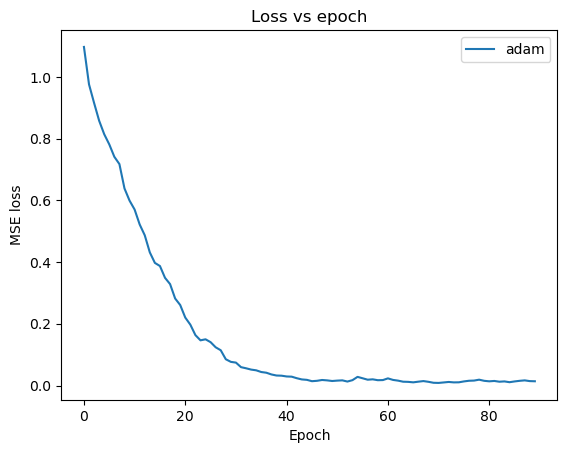

In [426]:
print(type(history_adam))
plt.plot(history_adam.history['loss'], label = 'adam')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Loss vs epoch")
plt.legend()
plt.show()

therefore will use adam optimiser

## tuning parameters

In [427]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [428]:
%%time
seed = 7,
numpy.random.seed(seed),
batch_size = 128,
epochs = 10

CPU times: user 55 µs, sys: 15 µs, total: 70 µs
Wall time: 70.1 µs


In [429]:
model_CV = KerasClassifier(build_fn=model_neuralnet_adam, epochs=epochs, 
                           batch_size=batch_size, verbose=1)

/private/tmp/PKInstallSandbox.n6XGm2/tmp/ipykernel_7954/609257151.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_CV = KerasClassifier(build_fn=model_neuralnet_adam, epochs=epochs,


In [430]:
# define the grid search parameters
init_mode= ["n_estimators", "max_depth", "min_samples_split", "learning_rate", "loss"]

In [431]:
param_grid = dict(init_mode=init_mode)

In [432]:
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)

In [433]:
#grid_result = grid.fit(x_train, y_train)

In [434]:
# error with M1/M2 macs? 